### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier
import joblib
import session_info

sns.set_style("darkgrid")

### Loading Dataset

In [ ]:
data = pd.read_csv("data_cardiovascular_risk.csv", index_col="id")

### Dataset First View

In [ ]:
data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.00,F,YES,3.00,0.00,0,0,0,221.00,148.00,85.00,NaN,90.00,80.00,1
1,36,4.00,M,NO,0.00,0.00,0,1,0,212.00,168.00,98.00,29.77,72.00,75.00,0
2,46,1.00,F,YES,10.00,0.00,0,0,0,250.00,116.00,71.00,20.35,88.00,94.00,0
3,50,1.00,M,YES,20.00,0.00,0,1,0,233.00,158.00,88.00,28.26,68.00,94.00,1
4,64,1.00,F,YES,30.00,0.00,0,0,0,241.00,136.50,85.00,26.42,70.00,77.00,0


### Dataset Rows and Columns count

In [ ]:
data.shape

(3390, 16)

### Dataset Information

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


#### Duplicate values

In [ ]:
dummy = data.copy()
dummy = dummy.drop_duplicates()
print(f"Dataset shape before dropping duplicates: {data.shape}")
print(f"Dataset shape after dropping duplicates: {dummy.shape}")

Dataset shape before dropping duplicates: (3390, 16)
Dataset shape after dropping duplicates: (3390, 16)


#### Missing / Null Values

In [ ]:
data.isnull().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

#### Visualizing missing data

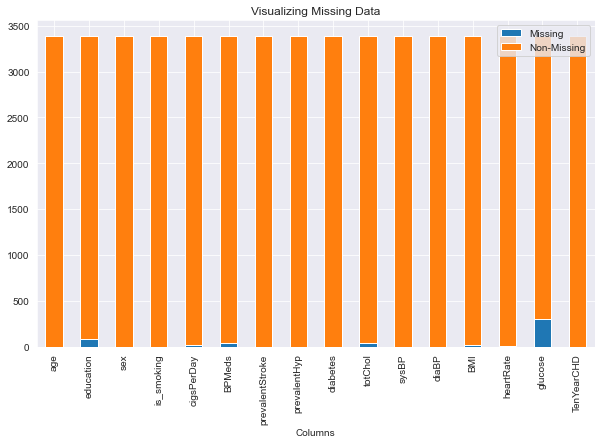

In [ ]:
non_missing = data.isnull().sum().apply(lambda x: data.shape[0] - x)
missing = data.isnull().sum()
missing_df = pd.concat([missing, non_missing], axis=1).reset_index()
missing_df.columns = ["Columns", "Missing", "Non-Missing"]
missing_df.plot.bar(x="Columns", stacked=True, figsize=(10, 6))
plt.title("Visualizing Missing Data")
plt.show()

### Understanding Variables

### Dataset Description

In [ ]:
data.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.00,3303.00,3368.00,3346.00,3390.00,3390.00,3390.00,3352.00,3390.00,3390.00,3376.00,3389.00,3086.00,3390.00
mean,49.54,1.97,9.07,0.03,0.01,0.32,0.03,237.07,132.60,82.88,25.79,75.98,82.09,0.15
std,8.59,1.02,11.88,0.17,0.08,0.46,0.16,45.25,22.29,12.02,4.12,11.97,24.24,0.36
min,32.00,1.00,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.96,45.00,40.00,0.00
25%,42.00,1.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,74.50,23.02,68.00,71.00,0.00
50%,49.00,2.00,0.00,0.00,0.00,0.00,0.00,234.00,128.50,82.00,25.38,75.00,78.00,0.00
75%,56.00,3.00,20.00,0.00,0.00,1.00,0.00,264.00,144.00,90.00,28.04,83.00,87.00,0.00
max,70.00,4.00,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


### Dataset Columns

In [ ]:
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

### Data Wrangling

### Grouping data by TenYearCHD risk

In [ ]:
data.groupby("TenYearCHD").mean().T

TenYearCHD,0,1
age,48.73,54.13
education,1.99,1.84
cigsPerDay,8.73,10.95
BPMeds,0.02,0.07
prevalentStroke,0.00,0.02
prevalentHyp,0.28,0.50
diabetes,0.02,0.06
totChol,235.28,247.22
sysBP,130.60,143.85
diaBP,82.19,86.76


Inference:
- People with risk of Coronary Heart Disease (CHD) are on average older than those who don't possess the risk.
- People with risk of CHD tend to smoke more cigarettes when compared to ones who don't possess the risk.
- People with the risk of CHD on average have higher Blood Pressure (systolic and diastolic) when compared to those who don't. 
- People with risk of CHD on average also have slightly higher Body Mass Index (BMI) and heart rate than who don't possess the risk.
- People with the risk of CHD on average have higher gluclose levels when compared to those who don't possess the risk. 

### Grouping data by sex

In [ ]:
data.groupby("sex").mean().T

sex,F,M
age,49.86,49.13
education,1.94,2.01
cigsPerDay,5.63,13.59
BPMeds,0.04,0.02
prevalentStroke,0.01,0.01
prevalentHyp,0.31,0.32
diabetes,0.02,0.03
totChol,239.90,233.43
sysBP,133.33,131.65
diaBP,82.27,83.69


Inference:
- Men on average tend to smoke more cigerettes per day when compared to women.
- Women on average tend to have higher heart rate, glucose levels, total cholestrol levels and systolilc BP when compared to men.
- Men on average have higher body mass index when compared to women.

### Grouping data by smokers

In [ ]:
data.groupby("is_smoking").mean().T

is_smoking,NO,YES
age,51.35,47.72
education,1.94,2.00
cigsPerDay,0.00,18.35
BPMeds,0.04,0.02
prevalentStroke,0.01,0.00
prevalentHyp,0.37,0.26
diabetes,0.03,0.02
totChol,239.19,234.93
sysBP,135.83,129.34
diaBP,84.37,81.38


Inference:
- On average, the smoking grop of the given dataset smoke about 18 cigarettes per day.
- On average, the smoking group of the given dataset have lower levels of total cholestrol, blood pressure, BMI and glucose levels.
- On average, the smoking group tend to have a slightly higher heart rate when compared to non-smoking group

### Grouping data by Diabetes

In [ ]:
data.groupby("diabetes").mean().T

diabetes,0,1
age,49.39,55.25
education,1.98,1.64
cigsPerDay,9.16,5.49
BPMeds,0.03,0.10
prevalentStroke,0.01,0.01
prevalentHyp,0.31,0.55
totChol,236.64,253.45
sysBP,132.15,149.63
diaBP,82.76,87.41
BMI,25.74,28.08


Inference:
- On average, people with diabetes have higher total cholestrol levels, blood pressure, BMI, heart rate and significantly higher levels of glucose. They also possess a greater risk of CHD.

### Grouping data by Prevalent Hypertension

In [ ]:
data.groupby("prevalentHyp").mean().T

prevalentHyp,0,1
age,47.74,53.45
education,2.03,1.84
cigsPerDay,9.71,7.68
BPMeds,0.00,0.10
prevalentStroke,0.00,0.01
diabetes,0.02,0.04
totChol,232.18,247.73
sysBP,122.02,155.57
diaBP,77.88,93.74
BMI,24.96,27.62


Inference:
- On average, people with prevalent history of hyper tension have higher total cholestrol, blood pressure, BMI, heart rate and glucose levels. They also possess greater risk of contracting CHD.

### Grouping data by Prevalent Stroke

In [ ]:
data.groupby("prevalentStroke").mean().T

prevalentStroke,0,1
age,49.50,55.82
education,1.97,1.55
cigsPerDay,9.11,2.91
BPMeds,0.03,0.29
prevalentHyp,0.31,0.73
diabetes,0.03,0.05
totChol,237.11,231.05
sysBP,132.50,148.48
diaBP,82.84,89.91
BMI,25.79,26.79


Inference:
- On average, people with a prevalent history of stroke have higher BP, BMI and glucose levels than those who don't. They also possess a significantly greater risk of contracting a CHD.
- People with prevalent history of stroke, also on average tend to have lower levels of cholestrol and heart rate when conmpared to those who don't.

### Grouping data by Blood Pressure Meds

In [ ]:
data.groupby("BPMeds").mean().T

BPMeds,0.00,1.00
age,49.30,55.56
education,1.98,1.86
cigsPerDay,9.16,6.58
prevalentStroke,0.00,0.06
prevalentHyp,0.29,1.00
diabetes,0.02,0.09
totChol,236.36,258.66
sysBP,131.47,165.89
diaBP,82.44,96.59
BMI,25.74,27.86


Inference:
- On average, people who are on blood pressure medicines tend to have higher total cholestrol, BP, BMI, heart rate and glucose levels than those who don't.
- They also have high chances of have a stroke, diabetes and CHD.